In [4]:
import torch
import torch.nn as nn
import torch.utils.data as data
from dataloader import read_bci_data
from EEGnet import EEGnet
from DeepConvNet import DeepConvNet

import matplotlib.pyplot as plt

device = torch.device("cuda")
EPOCH = 300

In [5]:
class MyDataset(data.Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels

    def __getitem__(self, index):
        img, target = self.datas[index], self.labels[index]
        return img, target

    def __len__(self):
        return len(self.datas)


train_data, train_label, test_data, test_label = read_bci_data()

train_data = torch.Tensor(train_data).to(device)
train_label = torch.Tensor(train_label).type(torch.LongTensor).to(device)
test_data = torch.Tensor(test_data).to(device)
test_label = torch.Tensor(test_label).type(torch.LongTensor).to(device)

dataset = MyDataset(train_data, train_label)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)


Epoch    16: reducing learning rate of group 0 to 1.0000e-02.
Epoch    37: reducing learning rate of group 0 to 5.0000e-03.
Epoch    58: reducing learning rate of group 0 to 2.5000e-03.
Epoch    79: reducing learning rate of group 0 to 1.2500e-03.
Epoch   100: reducing learning rate of group 0 to 6.2500e-04.
Epoch   121: reducing learning rate of group 0 to 3.1250e-04.
Epoch   142: reducing learning rate of group 0 to 1.5625e-04.
Epoch   163: reducing learning rate of group 0 to 7.8125e-05.
Epoch   184: reducing learning rate of group 0 to 3.9063e-05.
Epoch   205: reducing learning rate of group 0 to 1.9531e-05.
Epoch   226: reducing learning rate of group 0 to 1.0000e-05.


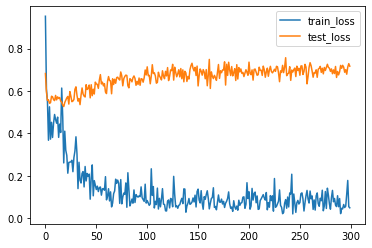

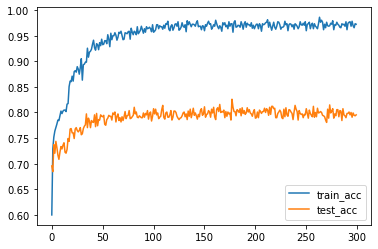

best acc:  tensor(0.8259, device='cuda:0')


EEGnet(
  (firstconv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (depthwiseConv): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 1), stride=(1, 1), groups=16, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (separableConv): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classify): Linear(in_features=736, out_features=2, bias=True)
)

In [6]:
net = EEGnet(nn.ReLU()).to(device)
#net = DeepConvNet(nn.ELU()).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.02)
loss = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True, min_lr=0.00001, cooldown=10)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
best_test_acc = 0

for epoch in range(1, EPOCH+1):
    total_acc = 0
    total_item = 0
    for (x, y_true) in train_loader:
        y_pred = net(x)
        output = loss(y_pred, y_true)
        net.zero_grad()
        output.backward()
        optimizer.step()


        _, y_pred = torch.max(y_pred.data, 1)
        total_acc += (y_pred == y_true).sum()
        total_item += y_pred.shape[0]

    accuracy = total_acc / total_item
    train_loss.append(output.item())
    train_acc.append(accuracy)
    #print(f"epoch: {epoch}/{EPOCH}, Training loss: {output.item()}, Training accuracy: {accuracy}")


    with torch.no_grad():
        y_pred = net(test_data)
        output = loss(y_pred, test_label)

    _, y_pred = torch.max(y_pred.data, 1)
    accuracy = (y_pred == test_label).sum()/train_data.shape[0]
    test_loss.append(output.item())
    test_acc.append(accuracy)
    #print(f"Test loss: {output.item()}, Test accuracy: {accuracy}")
    if accuracy > best_test_acc:
        best_test_acc = accuracy

    scheduler.step(output.item())

plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()
plt.show()
plt.plot(train_acc, label="train_acc")
plt.plot(test_acc, label="test_acc")
plt.legend()
plt.show()

print("best acc: ", best_test_acc)


net.eval()
